In [1]:
import pandas as pd
import numpy as np
from shapely.wkt import loads
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from SimuSamp.functions.load.SpatDat import SpatDat
import geopandas as gpd
import scipy.stats as stats

# Compare Simulated TMA Data to Whole-Slide Data

In [2]:
parent_filepath = "../../../../Simulated WS Sampling/block_data"

sampleids = ["01_F", "01_G", "02_G", "02_H", "03_B", "03_H", "04_I", "04_N", "05_G", "05_I", "06_H", "07_K", "08_J", "09_E", "10_B", "11_E", "11_F", "12_M", "13_G", "14_I", "15_G", "16_B", "17_I", "18_E", "19_F", "21_I", "22_N", "23_B", "24_I", "25_M", "26_I", "27_H", "28_FSC", "29_L", "30_D"]

microns_per_pixel=0.22715
mm2_per_pixels2 = (microns_per_pixel / 1000) ** 2

font_dict = {"fontsize": 16, "fontweight": "bold", "fontname": "Arial"}

## Load and Pre-Process Data

In [ ]:
# Whole-slide data generated from wholeslide_stats.ipynb

ws = pd.read_excel("../../../../Data/WS_stats.xlsx")

ws = ws.rename(columns={"sample": "sampleid", "annotation": "region", "density": "ws_density", "n_neighbour": "ws_n_neighbour"})

ws["ws_n_neighbour"] = ws["ws_n_neighbour"] * microns_per_pixel

ws = ws[ws["region"].isin(["tumour", "outer_IM"])].reset_index(drop=True)

In [ ]:
# Simulated TMA data generated from WS_simulated_TMA_sampling.ipynb

tma = pd.read_excel("../../../../Data/Simulated/simulation_results.xlsx")

tma["region"] = tma["region"].replace({"IM": "outer_IM"})

tma_total = tma.merge(ws[["sampleid", "region", "ws_density", "ws_n_neighbour"]], on=["sampleid", "region"], how="left")

tma_total["den_error_abs"] =abs(tma_total["density_mean"] - tma_total["ws_density"])

tma_total["den_error"] = abs(tma_total["density_mean"] - tma_total["ws_density"]) / tma_total["ws_density"]

tma_total["nn_error"] = abs(tma_total["nearest_neighbour_mean"] - tma_total["ws_n_neighbour"]) / tma_total["ws_n_neighbour"]

In [5]:
# Get TMA data per core size (diameters)

tum_600 = tma_total[(tma_total["region"] == "tumour") & (tma_total["core_radius"] == 0.3)].reset_index(drop=True)
tum_1000 = tma_total[(tma_total["region"] == "tumour") & (tma_total["core_radius"] == 0.5)].reset_index(drop=True)
tum_2000 = tma_total[(tma_total["region"] == "tumour") & (tma_total["core_radius"] == 1.0)].reset_index(drop=True)

im_600 = tma_total[(tma_total["region"] == "outer_IM") & (tma_total["core_radius"] == 0.3)].reset_index(drop=True)
im_1000 = tma_total[(tma_total["region"] == "outer_IM") & (tma_total["core_radius"] == 0.5)].reset_index(drop=True)
im_2000 = tma_total[(tma_total["region"] == "outer_IM") & (tma_total["core_radius"] == 1.0)].reset_index(drop=True)

## Plot Whole-Slide vs Simulated TMA Comparisons

### Line Plots

#### Mean Density Std

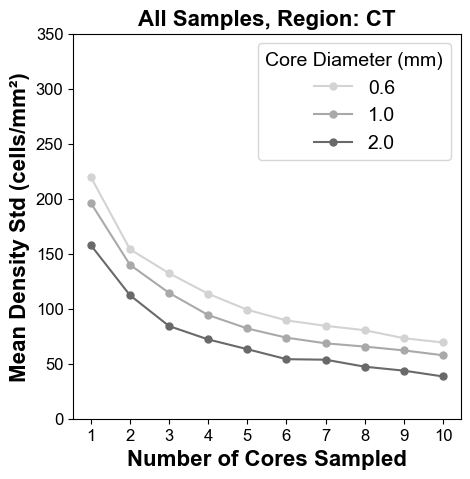

In [6]:
plot_data_600 = tum_600.groupby(["sampleid", "n_sampled"])["density_mean"].std().reset_index().groupby("n_sampled")["density_mean"].mean()
plot_data_1000 = tum_1000.groupby(["sampleid", "n_sampled"])["density_mean"].std().reset_index().groupby("n_sampled")["density_mean"].mean()
plot_data_2000 = tum_2000.groupby(["sampleid", "n_sampled"])["density_mean"].std().reset_index().groupby("n_sampled")["density_mean"].mean()

fig, ax = plt.subplots(figsize=(5, 5))

plt.plot(plot_data_600.index, plot_data_600, label="0.6", color="lightgrey", marker="o", markersize=5)
plt.plot(plot_data_1000.index, plot_data_1000, label="1.0", color="darkgrey", marker="o", markersize=5)
plt.plot(plot_data_2000.index, plot_data_2000, label="2.0", color="dimgrey", marker="o", markersize=5)

plt.xlabel("Number of Cores Sampled", fontdict=font_dict)
plt.ylabel("Mean Density Std (cells/mm\u00b2)", fontdict=font_dict)

plt.xticks(np.arange(1, 11), fontsize=12, fontname="Arial")
plt.yticks(fontsize=12, fontname="Arial")

# plt.gca().spines["top"].set_visible(False)
# plt.gca().spines["right"].set_visible(False)

plt.ylim(0, 350)

plt.legend(title="Core Diameter (mm)", prop={"size": 14, "family": "Arial"}, title_fontproperties={"size": 14, "family": "Arial"})

# plt.axhline(20, color="red", linestyle="--")

plt.title(f"All Samples, Region: CT", fontdict=font_dict)

plt.savefig(f"../../../../Data/Plots/DensityError/PerSampleLine/allsamples_tumour_meandenstd.png", dpi=600, transparent=True, bbox_inches="tight")

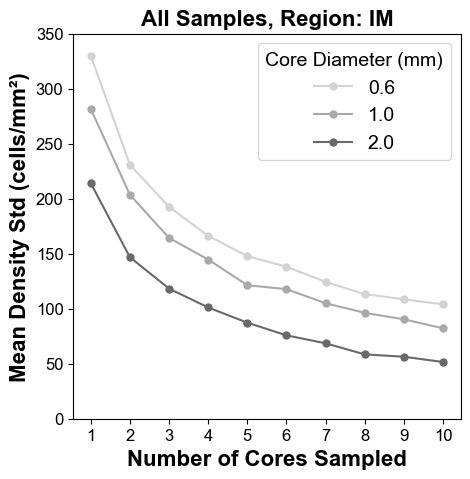

In [6]:
plot_data_600 = im_600.groupby(["sampleid", "n_sampled"])["density_mean"].std().reset_index().groupby("n_sampled")["density_mean"].mean()
plot_data_1000 = im_1000.groupby(["sampleid", "n_sampled"])["density_mean"].std().reset_index().groupby("n_sampled")["density_mean"].mean()
plot_data_2000 = im_2000.groupby(["sampleid", "n_sampled"])["density_mean"].std().reset_index().groupby("n_sampled")["density_mean"].mean()

fig, ax = plt.subplots(figsize=(5, 5))

plt.plot(plot_data_600.index, plot_data_600, label="0.6", color="lightgrey", marker="o", markersize=5)
plt.plot(plot_data_1000.index, plot_data_1000, label="1.0", color="darkgrey", marker="o", markersize=5)
plt.plot(plot_data_2000.index, plot_data_2000, label="2.0", color="dimgrey", marker="o", markersize=5)

plt.xlabel("Number of Cores Sampled", fontdict=font_dict)
plt.ylabel("Mean Density Std (cells/mm\u00b2)", fontdict=font_dict)

plt.xticks(np.arange(1, 11), fontsize=12, fontname="Arial")
plt.yticks(fontsize=12, fontname="Arial")

# plt.gca().spines["top"].set_visible(False)
# plt.gca().spines["right"].set_visible(False)

plt.ylim(0, 350)

plt.legend(title="Core Diameter (mm)", prop={"size": 14, "family": "Arial"}, title_fontproperties={"size": 14, "family": "Arial"})

# plt.axhline(20, color="red", linestyle="--")

plt.title(f"All Samples, Region: IM", fontdict=font_dict)

plt.savefig(f"../../../../Data/Plots/DensityError/PerSampleLine/allsamples_IM_meandenstd.png", dpi=600, transparent=True, bbox_inches="tight")

#### Coefficient of Variation

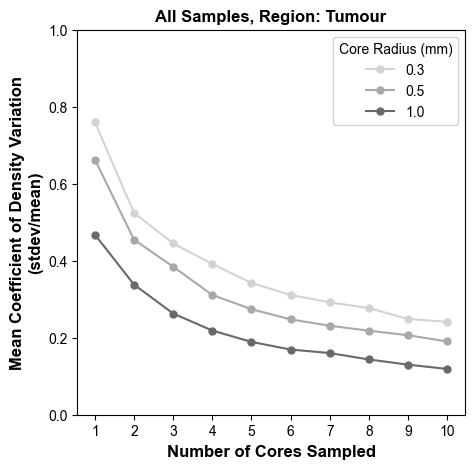

In [ ]:
plot_data_600 = tum_600.groupby(["sampleid", "n_sampled"])["density_mean"].agg(mean_density="mean", std_density="std").reset_index()
plot_data_1000 = tum_1000.groupby(["sampleid", "n_sampled"])["density_mean"].agg(mean_density="mean", std_density="std").reset_index()
plot_data_2000 = tum_2000.groupby(["sampleid", "n_sampled"])["density_mean"].agg(mean_density="mean", std_density="std").reset_index()

plot_data_600["cv_density"] = plot_data_600["std_density"] / plot_data_600["mean_density"]
plot_data_1000["cv_density"] = plot_data_1000["std_density"] / plot_data_1000["mean_density"]
plot_data_2000["cv_density"] = plot_data_2000["std_density"] / plot_data_2000["mean_density"]

plot_data_600 = plot_data_600.groupby("n_sampled")["cv_density"].mean().reset_index()
plot_data_1000 = plot_data_1000.groupby("n_sampled")["cv_density"].mean().reset_index()
plot_data_2000 = plot_data_2000.groupby("n_sampled")["cv_density"].mean().reset_index()

fig, ax = plt.subplots(figsize=(5, 5))

plt.plot(plot_data_600["n_sampled"], plot_data_600["cv_density"], label="0.3", color="lightgrey", marker="o", markersize=5)
plt.plot(plot_data_1000["n_sampled"], plot_data_1000["cv_density"], label="0.5", color="darkgrey", marker="o", markersize=5)
plt.plot(plot_data_2000["n_sampled"], plot_data_2000["cv_density"], label="1.0", color="dimgrey", marker="o", markersize=5)

plt.xlabel("Number of Cores Sampled", fontdict=font_dict)
plt.ylabel("Mean Coefficient of Density Variation\n(stdev/mean)", fontdict=font_dict)

plt.xticks(np.arange(1, 11), fontsize=10, fontname="Arial")
plt.yticks(fontsize=10, fontname="Arial")

# plt.gca().spines["top"].set_visible(False)
# plt.gca().spines["right"].set_visible(False)

plt.ylim(0, 1)

plt.legend(title="Core Radius (mm)", prop={"size": 10, "family": "Arial"}, title_fontproperties={"size": 10, "family": "Arial"})

# plt.axhline(20, color="red", linestyle="--")

plt.title(f"All Samples, Region: Tumour", fontdict=font_dict)

plt.savefig(f"../../../../Data/Plots/DensityError/PerSampleLine/allsamples_tumour_meandencv.png", dpi=300, transparent=True, bbox_inches="tight")

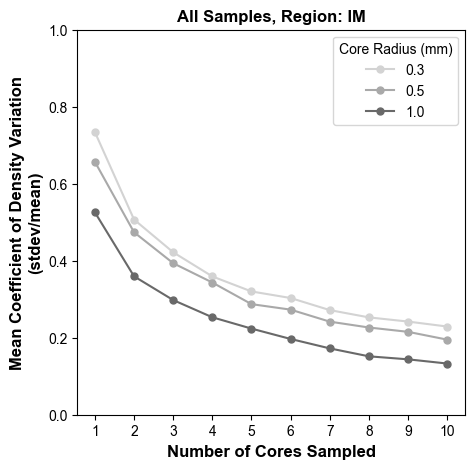

In [14]:
plot_data_600 = im_600.groupby(["sampleid", "n_sampled"])["density_mean"].agg(mean_density="mean", std_density="std").reset_index()
plot_data_1000 = im_1000.groupby(["sampleid", "n_sampled"])["density_mean"].agg(mean_density="mean", std_density="std").reset_index()
plot_data_2000 = im_2000.groupby(["sampleid", "n_sampled"])["density_mean"].agg(mean_density="mean", std_density="std").reset_index()

plot_data_600["cv_density"] = plot_data_600["std_density"] / plot_data_600["mean_density"]
plot_data_1000["cv_density"] = plot_data_1000["std_density"] / plot_data_1000["mean_density"]
plot_data_2000["cv_density"] = plot_data_2000["std_density"] / plot_data_2000["mean_density"]

plot_data_600 = plot_data_600.groupby("n_sampled")["cv_density"].mean().reset_index()
plot_data_1000 = plot_data_1000.groupby("n_sampled")["cv_density"].mean().reset_index()
plot_data_2000 = plot_data_2000.groupby("n_sampled")["cv_density"].mean().reset_index()

fig, ax = plt.subplots(figsize=(5, 5))

plt.plot(plot_data_600["n_sampled"], plot_data_600["cv_density"], label="0.3", color="lightgrey", marker="o", markersize=5)
plt.plot(plot_data_1000["n_sampled"], plot_data_1000["cv_density"], label="0.5", color="darkgrey", marker="o", markersize=5)
plt.plot(plot_data_2000["n_sampled"], plot_data_2000["cv_density"], label="1.0", color="dimgrey", marker="o", markersize=5)

plt.xlabel("Number of Cores Sampled", fontdict=font_dict)
plt.ylabel("Mean Coefficient of Density Variation\n(stdev/mean)", fontdict=font_dict)

plt.xticks(np.arange(1, 11), fontsize=10, fontname="Arial")
plt.yticks(fontsize=10, fontname="Arial")

# plt.gca().spines["top"].set_visible(False)
# plt.gca().spines["right"].set_visible(False)

plt.ylim(0, 1)

plt.legend(title="Core Radius (mm)", prop={"size": 10, "family": "Arial"}, title_fontproperties={"size": 10, "family": "Arial"})

# plt.axhline(20, color="red", linestyle="--")

plt.title(f"All Samples, Region: IM", fontdict=font_dict)

plt.savefig(f"../../../../Data/Plots/DensityError/PerSampleLine/allsamples_IM_meandencv.png", dpi=300, transparent=True, bbox_inches="tight")

#### Mean Density Error (Relative)

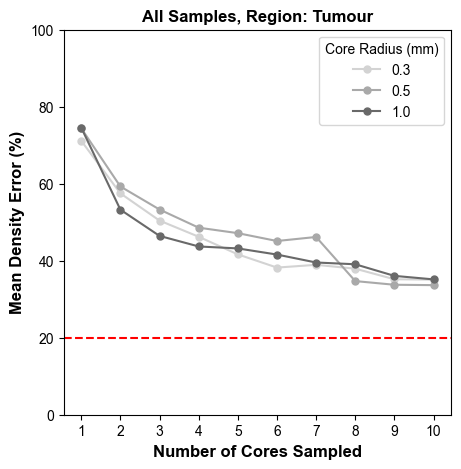

In [14]:

plot_data_600 = tum_600.groupby(["sampleid", "n_sampled"])["den_error"].mean().reset_index().groupby("n_sampled")["den_error"].mean()
plot_data_1000 = tum_1000.groupby(["sampleid", "n_sampled"])["den_error"].mean().reset_index().groupby("n_sampled")["den_error"].mean()
plot_data_2000 = tum_2000.groupby(["sampleid", "n_sampled"])["den_error"].mean().reset_index().groupby("n_sampled")["den_error"].mean()

fig, ax = plt.subplots(figsize=(5, 5))

plt.plot(plot_data_600.index, plot_data_600 * 100, label="0.3", color="lightgrey", marker="o", markersize=5)
plt.plot(plot_data_1000.index, plot_data_1000 * 100, label="0.5", color="darkgrey", marker="o", markersize=5)
plt.plot(plot_data_2000.index, plot_data_2000 * 100, label="1.0", color="dimgrey", marker="o", markersize=5)

plt.xlabel("Number of Cores Sampled", fontdict=font_dict)
plt.ylabel("Mean Density Error (%)", fontdict=font_dict)

plt.xticks(np.arange(1, 11), fontsize=10, fontname="Arial")
plt.yticks(fontsize=10, fontname="Arial")

# plt.gca().spines["top"].set_visible(False)
# plt.gca().spines["right"].set_visible(False)

plt.ylim(0, 100)

plt.legend(title="Core Radius (mm)", prop={"size": 10, "family": "Arial"}, title_fontproperties={"size": 10, "family": "Arial"})

plt.axhline(20, color="red", linestyle="--")

plt.title(f"All Samples, Region: Tumour", fontdict=font_dict)

plt.savefig(f"../../../../Data/Plots/DensityError/PerSampleLine/allsamples_tumour_meandenerror.png", dpi=300, transparent=True)

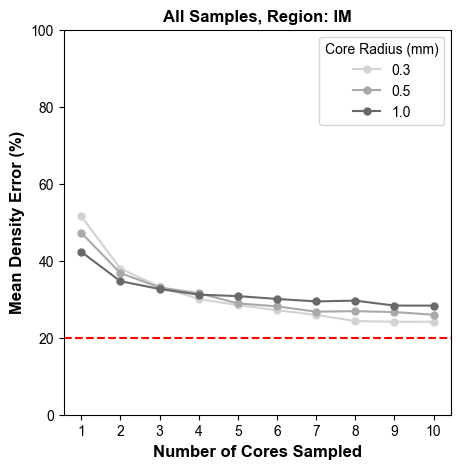

In [15]:
plot_data_600 = im_600.groupby(["sampleid", "n_sampled"])["den_error"].mean().reset_index().groupby("n_sampled")["den_error"].mean()
plot_data_1000 = im_1000.groupby(["sampleid", "n_sampled"])["den_error"].mean().reset_index().groupby("n_sampled")["den_error"].mean()
plot_data_2000 = im_2000.groupby(["sampleid", "n_sampled"])["den_error"].mean().reset_index().groupby("n_sampled")["den_error"].mean()

fig, ax = plt.subplots(figsize=(5, 5))

plt.plot(plot_data_600.index, plot_data_600 * 100, label="0.3", color="lightgrey", marker="o", markersize=5)
plt.plot(plot_data_1000.index, plot_data_1000 * 100, label="0.5", color="darkgrey", marker="o", markersize=5)
plt.plot(plot_data_2000.index, plot_data_2000 * 100, label="1.0", color="dimgrey", marker="o", markersize=5)

plt.xlabel("Number of Cores Sampled", fontdict=font_dict)
plt.ylabel("Mean Density Error (%)", fontdict=font_dict)

plt.xticks(np.arange(1, 11), fontsize=10, fontname="Arial")
plt.yticks(fontsize=10, fontname="Arial")

# plt.gca().spines["top"].set_visible(False)
# plt.gca().spines["right"].set_visible(False)

plt.ylim(0, 100)

plt.legend(title="Core Radius (mm)", prop={"size": 10, "family": "Arial"}, title_fontproperties={"size": 10, "family": "Arial"})

plt.axhline(20, color="red", linestyle="--")

plt.title(f"All Samples, Region: IM", fontdict=font_dict)

plt.savefig(f"../../../../Data/Plots/DensityError/PerSampleLine/allsamples_IM_meandenerror.png", dpi=300, transparent=True)

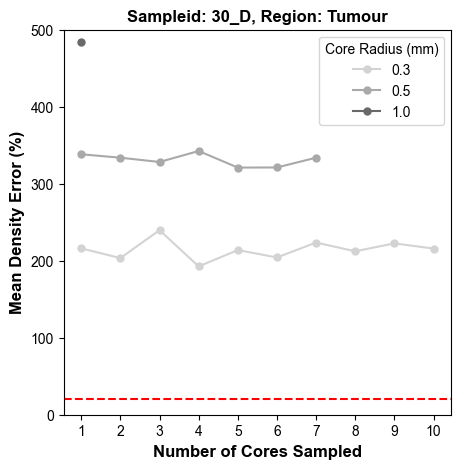

In [19]:
for sampleid in sampleids:
    plt.cla()
    plt.clf()
    plt.close()
    
    plot_data_600 = tum_600[tum_600["sampleid"] == sampleid].groupby("n_sampled")["den_error"].mean()
    plot_data_1000 = tum_1000[tum_1000["sampleid"] == sampleid].groupby("n_sampled")["den_error"].mean()
    plot_data_2000 = tum_2000[tum_2000["sampleid"] == sampleid].groupby("n_sampled")["den_error"].mean()

    fig, ax = plt.subplots(figsize=(5, 5))

    plt.plot(plot_data_600.index, plot_data_600 * 100, label="0.3", color="lightgrey", marker="o", markersize=5)
    plt.plot(plot_data_1000.index, plot_data_1000 * 100, label="0.5", color="darkgrey", marker="o", markersize=5)
    plt.plot(plot_data_2000.index, plot_data_2000 * 100, label="1.0", color="dimgrey", marker="o", markersize=5)

    plt.xlabel("Number of Cores Sampled", fontdict=font_dict)
    plt.ylabel("Mean Density Error (%)", fontdict=font_dict)

    plt.xticks(np.arange(1, 11), fontsize=10, fontname="Arial")
    plt.yticks(fontsize=10, fontname="Arial")

    # plt.gca().spines["top"].set_visible(False)
    # plt.gca().spines["right"].set_visible(False)

    if sampleid in ["03_B", "30_D"]:
        plt.ylim(0, 500)
    else:
        plt.ylim(0, 200)

    plt.legend(title="Core Radius (mm)", prop={"size": 10, "family": "Arial"}, title_fontproperties={"size": 10, "family": "Arial"})

    plt.axhline(20, color="red", linestyle="--")

    plt.title(f"Sampleid: {sampleid}, Region: Tumour", fontdict=font_dict)

    plt.savefig(f"../../../../Data/Plots/DensityError/PerSampleLine/{sampleid}_tumour_meandenerror.png", dpi=300, transparent=True)

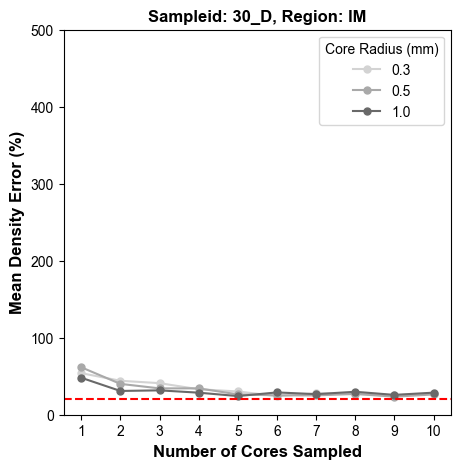

In [18]:
for sampleid in sampleids:
    plt.cla()
    plt.clf()
    plt.close()
    
    plot_data_600 = im_600[im_600["sampleid"] == sampleid].groupby("n_sampled")["den_error"].mean()
    plot_data_1000 = im_1000[im_1000["sampleid"] == sampleid].groupby("n_sampled")["den_error"].mean()
    plot_data_2000 = im_2000[im_2000["sampleid"] == sampleid].groupby("n_sampled")["den_error"].mean()

    fig, ax = plt.subplots(figsize=(5, 5))

    plt.plot(plot_data_600.index, plot_data_600 * 100, label="0.3", color="lightgrey", marker="o", markersize=5)
    plt.plot(plot_data_1000.index, plot_data_1000 * 100, label="0.5", color="darkgrey", marker="o", markersize=5)
    plt.plot(plot_data_2000.index, plot_data_2000 * 100, label="1.0", color="dimgrey", marker="o", markersize=5)

    plt.xlabel("Number of Cores Sampled", fontdict=font_dict)
    plt.ylabel("Mean Density Error (%)", fontdict=font_dict)

    plt.xticks(np.arange(1, 11), fontsize=10, fontname="Arial")
    plt.yticks(fontsize=10, fontname="Arial")

    # plt.gca().spines["top"].set_visible(False)
    # plt.gca().spines["right"].set_visible(False)

    if sampleid in ["03_B", "30_D"]:
        plt.ylim(0, 500)
    else:
        plt.ylim(0, 200)

    plt.legend(title="Core Radius (mm)", prop={"size": 10, "family": "Arial"}, title_fontproperties={"size": 10, "family": "Arial"})

    plt.axhline(20, color="red", linestyle="--")

    plt.title(f"Sampleid: {sampleid}, Region: IM", fontdict=font_dict)

    plt.savefig(f"../../../../Data/Plots/DensityError/PerSampleLine/{sampleid}_IM_meandenerror.png", dpi=300, transparent=True)

#### Mean Density Error (Absolute)

In [24]:
ws_tum_mean = ws[ws["region"] == "tumour"]["ws_density"].mean()
ws_im_mean = ws[ws["region"] == "outer_IM"]["ws_density"].mean()

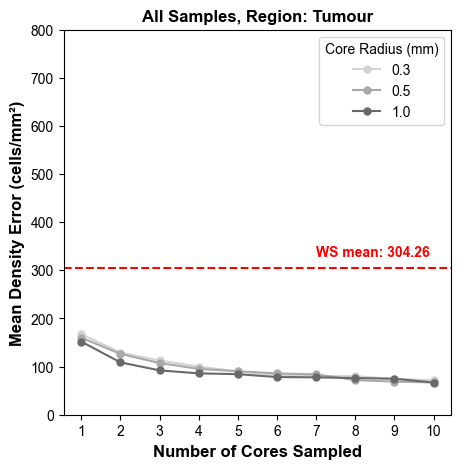

In [40]:
plot_data_600 = tum_600.groupby(["sampleid", "n_sampled"])["den_error_abs"].mean().reset_index().groupby("n_sampled")["den_error_abs"].mean()
plot_data_1000 = tum_1000.groupby(["sampleid", "n_sampled"])["den_error_abs"].mean().reset_index().groupby("n_sampled")["den_error_abs"].mean()
plot_data_2000 = tum_2000.groupby(["sampleid", "n_sampled"])["den_error_abs"].mean().reset_index().groupby("n_sampled")["den_error_abs"].mean()

fig, ax = plt.subplots(figsize=(5, 5))

plt.plot(plot_data_600.index, plot_data_600, label="0.3", color="lightgrey", marker="o", markersize=5)
plt.plot(plot_data_1000.index, plot_data_1000, label="0.5", color="darkgrey", marker="o", markersize=5)
plt.plot(plot_data_2000.index, plot_data_2000, label="1.0", color="dimgrey", marker="o", markersize=5)

plt.xlabel("Number of Cores Sampled", fontdict=font_dict)
plt.ylabel("Mean Density Error (cells/mm\u00b2)", fontdict=font_dict)

plt.xticks(np.arange(1, 11), fontsize=10, fontname="Arial")
plt.yticks(fontsize=10, fontname="Arial")

# plt.gca().spines["top"].set_visible(False)
# plt.gca().spines["right"].set_visible(False)

plt.ylim(0, 800)

plt.legend(title="Core Radius (mm)", prop={"size": 10, "family": "Arial"}, title_fontproperties={"size": 10, "family": "Arial"})

plt.axhline(ws_tum_mean, color="red", linestyle="--")
plt.text(7, ws_tum_mean + 25, f"WS mean: {round(ws_tum_mean, 2)}", fontweight="bold", fontname="Arial", fontsize=10, color="red")

plt.title(f"All Samples, Region: Tumour", fontdict=font_dict)

plt.savefig(f"../../../../Data/Plots/DensityError/PerSampleLineAbs/allsamples_tumour_meandenerrorabs.png", dpi=300, transparent=True)

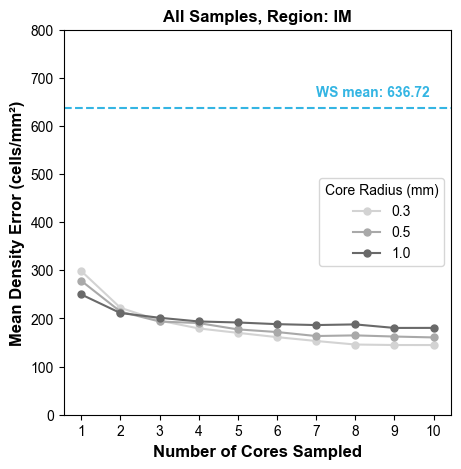

In [39]:
plot_data_600 = im_600.groupby(["sampleid", "n_sampled"])["den_error_abs"].mean().reset_index().groupby("n_sampled")["den_error_abs"].mean()
plot_data_1000 = im_1000.groupby(["sampleid", "n_sampled"])["den_error_abs"].mean().reset_index().groupby("n_sampled")["den_error_abs"].mean()
plot_data_2000 = im_2000.groupby(["sampleid", "n_sampled"])["den_error_abs"].mean().reset_index().groupby("n_sampled")["den_error_abs"].mean()

fig, ax = plt.subplots(figsize=(5, 5))

plt.plot(plot_data_600.index, plot_data_600, label="0.3", color="lightgrey", marker="o", markersize=5)
plt.plot(plot_data_1000.index, plot_data_1000, label="0.5", color="darkgrey", marker="o", markersize=5)
plt.plot(plot_data_2000.index, plot_data_2000, label="1.0", color="dimgrey", marker="o", markersize=5)

plt.xlabel("Number of Cores Sampled", fontdict=font_dict)
plt.ylabel("Mean Density Error (cells/mm\u00b2)", fontdict=font_dict)

plt.xticks(np.arange(1, 11), fontsize=10, fontname="Arial")
plt.yticks(fontsize=10, fontname="Arial")

# plt.gca().spines["top"].set_visible(False)
# plt.gca().spines["right"].set_visible(False)

plt.ylim(0, 800)

plt.legend(title="Core Radius (mm)", prop={"size": 10, "family": "Arial"}, title_fontproperties={"size": 10, "family": "Arial"})

plt.axhline(ws_im_mean, color=(52/255, 181/255, 227/255), linestyle="--")

plt.text(7, ws_im_mean + 25, f"WS mean: {round(ws_im_mean, 2)}", fontweight="bold", fontname="Arial", fontsize=10, color=(52/255, 181/255, 227/255))

plt.title(f"All Samples, Region: IM", fontdict=font_dict)

plt.savefig(f"../../../../Data/Plots/DensityError/PerSampleLineAbs/allsamples_IM_meandenerrorabs.png", dpi=300, transparent=True)

#### Mean Nearest Neighbour Distance Error

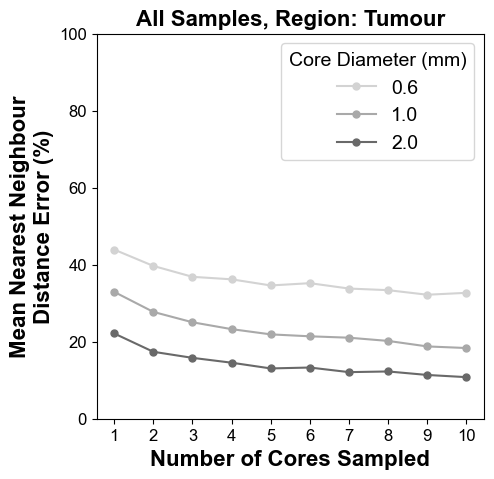

In [7]:
plot_data_600 = tum_600.groupby(["sampleid", "n_sampled"])["nn_error"].mean().reset_index().groupby("n_sampled")["nn_error"].mean()
plot_data_1000 = tum_1000.groupby(["sampleid", "n_sampled"])["nn_error"].mean().reset_index().groupby("n_sampled")["nn_error"].mean()
plot_data_2000 = tum_2000.groupby(["sampleid", "n_sampled"])["nn_error"].mean().reset_index().groupby("n_sampled")["nn_error"].mean()

fig, ax = plt.subplots(figsize=(5, 5))

plt.plot(plot_data_600.index, plot_data_600 * 100, label="0.6", color="lightgrey", marker="o", markersize=5)
plt.plot(plot_data_1000.index, plot_data_1000 * 100, label="1.0", color="darkgrey", marker="o", markersize=5)
plt.plot(plot_data_2000.index, plot_data_2000 * 100, label="2.0", color="dimgrey", marker="o", markersize=5)

plt.xlabel("Number of Cores Sampled", fontdict=font_dict)
plt.ylabel("Mean Nearest Neighbour\nDistance Error (%)", fontdict=font_dict)

plt.xticks(np.arange(1, 11), fontsize=12, fontname="Arial")
plt.yticks(fontsize=12, fontname="Arial")

# plt.gca().spines["top"].set_visible(False)
# plt.gca().spines["right"].set_visible(False)

plt.ylim(0, 100)

plt.legend(title="Core Diameter (mm)", prop={"size": 14, "family": "Arial"}, title_fontproperties={"size": 14, "family": "Arial"})

# plt.axhline(20, color="red", linestyle="--")

plt.title(f"All Samples, Region: Tumour", fontdict=font_dict)

plt.savefig(f"../../../../Data/Plots/NNError/PerSampleLine/allsamples_tumour_meanNNerror.png", dpi=600, transparent=True, bbox_inches="tight")

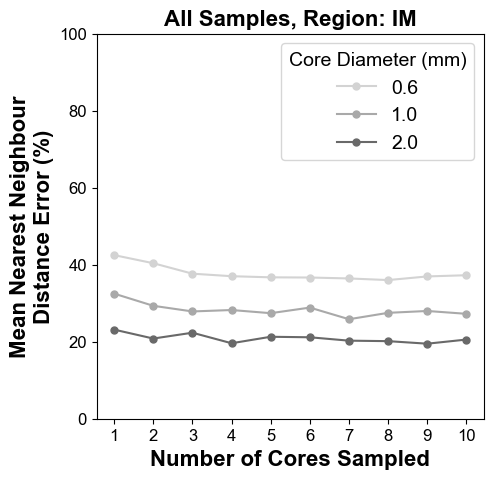

In [8]:
plot_data_600 = im_600.groupby(["sampleid", "n_sampled"])["nn_error"].mean().reset_index().groupby("n_sampled")["nn_error"].mean()
plot_data_1000 = im_1000.groupby(["sampleid", "n_sampled"])["nn_error"].mean().reset_index().groupby("n_sampled")["nn_error"].mean()
plot_data_2000 = im_2000.groupby(["sampleid", "n_sampled"])["nn_error"].mean().reset_index().groupby("n_sampled")["nn_error"].mean()

fig, ax = plt.subplots(figsize=(5, 5))

plt.plot(plot_data_600.index, plot_data_600 * 100, label="0.6", color="lightgrey", marker="o", markersize=5)
plt.plot(plot_data_1000.index, plot_data_1000 * 100, label="1.0", color="darkgrey", marker="o", markersize=5)
plt.plot(plot_data_2000.index, plot_data_2000 * 100, label="2.0", color="dimgrey", marker="o", markersize=5)

plt.xlabel("Number of Cores Sampled", fontdict=font_dict)
plt.ylabel("Mean Nearest Neighbour\nDistance Error (%)", fontdict=font_dict)

plt.xticks(np.arange(1, 11), fontsize=12, fontname="Arial")
plt.yticks(fontsize=12, fontname="Arial")

# plt.gca().spines["top"].set_visible(False)
# plt.gca().spines["right"].set_visible(False)

plt.ylim(0, 100)

plt.legend(title="Core Diameter (mm)", prop={"size": 14, "family": "Arial"}, title_fontproperties={"size": 14, "family": "Arial"})

# plt.axhline(20, color="red", linestyle="--")

plt.title(f"All Samples, Region: IM", fontdict=font_dict)

plt.savefig(f"../../../../Data/Plots/NNError/PerSampleLine/allsamples_IM_meanNNerror.png", dpi=600, transparent=True, bbox_inches="tight")

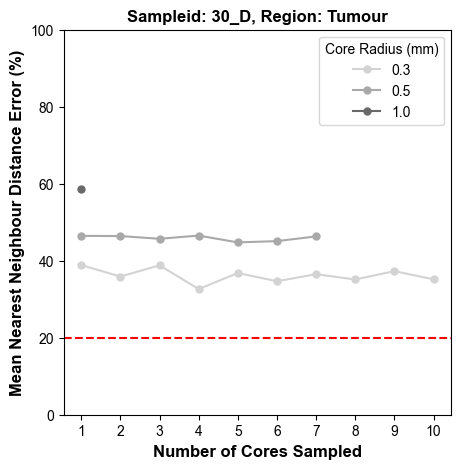

In [22]:
for sampleid in sampleids:
    plt.cla()
    plt.clf()
    plt.close()
    
    plot_data_600 = tum_600[tum_600["sampleid"] == sampleid].groupby("n_sampled")["nn_error"].mean()
    plot_data_1000 = tum_1000[tum_1000["sampleid"] == sampleid].groupby("n_sampled")["nn_error"].mean()
    plot_data_2000 = tum_2000[tum_2000["sampleid"] == sampleid].groupby("n_sampled")["nn_error"].mean()

    fig, ax = plt.subplots(figsize=(5, 5))

    plt.plot(plot_data_600.index, plot_data_600 * 100, label="0.3", color="lightgrey", marker="o", markersize=5)
    plt.plot(plot_data_1000.index, plot_data_1000 * 100, label="0.5", color="darkgrey", marker="o", markersize=5)
    plt.plot(plot_data_2000.index, plot_data_2000 * 100, label="1.0", color="dimgrey", marker="o", markersize=5)

    plt.xlabel("Number of Cores Sampled", fontdict=font_dict)
    plt.ylabel("Mean Nearest Neighbour Distance Error (%)", fontdict=font_dict)

    plt.xticks(np.arange(1, 11), fontsize=10, fontname="Arial")
    plt.yticks(fontsize=10, fontname="Arial")

    # plt.gca().spines["top"].set_visible(False)
    # plt.gca().spines["right"].set_visible(False)

    plt.ylim(0, 100)

    plt.legend(title="Core Radius (mm)", prop={"size": 10, "family": "Arial"}, title_fontproperties={"size": 10, "family": "Arial"})

    plt.axhline(20, color="red", linestyle="--")

    plt.title(f"Sampleid: {sampleid}, Region: Tumour", fontdict=font_dict)

    plt.savefig(f"../../../../Data/Plots/NNError/PerSampleLine/{sampleid}_tumour_meanNNerror.png", dpi=300, transparent=True)

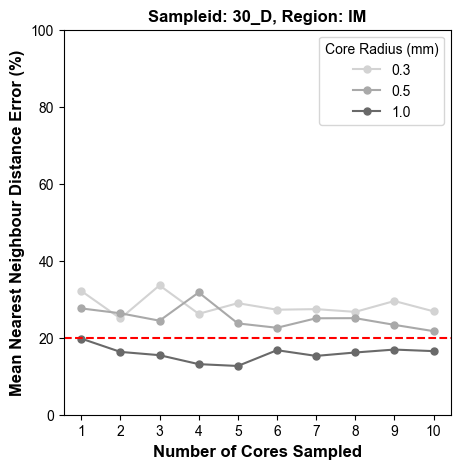

In [23]:
for sampleid in sampleids:
    plt.cla()
    plt.clf()
    plt.close()
    
    plot_data_600 = im_600[im_600["sampleid"] == sampleid].groupby("n_sampled")["nn_error"].mean()
    plot_data_1000 = im_1000[im_1000["sampleid"] == sampleid].groupby("n_sampled")["nn_error"].mean()
    plot_data_2000 = im_2000[im_2000["sampleid"] == sampleid].groupby("n_sampled")["nn_error"].mean()

    fig, ax = plt.subplots(figsize=(5, 5))

    plt.plot(plot_data_600.index, plot_data_600 * 100, label="0.3", color="lightgrey", marker="o", markersize=5)
    plt.plot(plot_data_1000.index, plot_data_1000 * 100, label="0.5", color="darkgrey", marker="o", markersize=5)
    plt.plot(plot_data_2000.index, plot_data_2000 * 100, label="1.0", color="dimgrey", marker="o", markersize=5)

    plt.xlabel("Number of Cores Sampled", fontdict=font_dict)
    plt.ylabel("Mean Nearest Neighbour Distance Error (%)", fontdict=font_dict)

    plt.xticks(np.arange(1, 11), fontsize=10, fontname="Arial")
    plt.yticks(fontsize=10, fontname="Arial")

    # plt.gca().spines["top"].set_visible(False)
    # plt.gca().spines["right"].set_visible(False)

    plt.ylim(0, 100)

    plt.legend(title="Core Radius (mm)", prop={"size": 10, "family": "Arial"}, title_fontproperties={"size": 10, "family": "Arial"})

    plt.axhline(20, color="red", linestyle="--")

    plt.title(f"Sampleid: {sampleid}, Region: IM", fontdict=font_dict)

    plt.savefig(f"../../../../Data/Plots/NNError/PerSampleLine/{sampleid}_IM_meanNNerror.png", dpi=300, transparent=True)

### Single-Sample Boxplots

#### Density Error

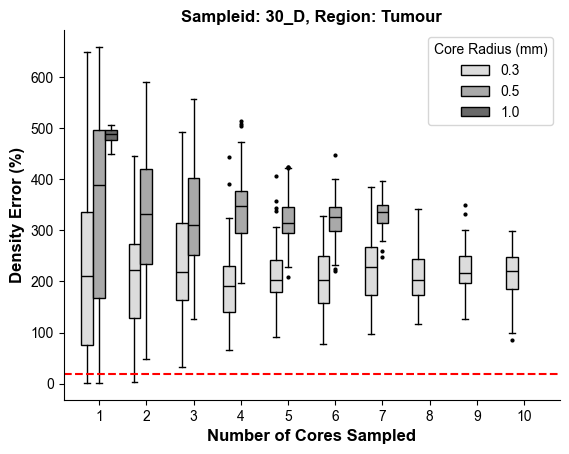

In [21]:
offset = 0.25
width = 0.25

positions = np.arange(1, 11)

for sampleid in sampleids:

    plt.cla()
    plt.clf()

    data_600 = [tum_600[(tum_600["sampleid"] == sampleid) & (tum_600["n_sampled"] == n)]["den_error"].values * 100 for n in positions]

    data_1000 = [tum_1000[(tum_1000["sampleid"] == sampleid) & (tum_1000["n_sampled"] == n)]["den_error"].values * 100 for n in positions]

    data_2000 = [tum_2000[(tum_2000["sampleid"] == sampleid) & (tum_2000["n_sampled"] == n)]["den_error"].values * 100 for n in positions]


    plt.boxplot(data_600, positions=[p - offset for p in positions], widths=width, label=0.3, flierprops=dict(marker="o", markerfacecolor="black", markersize=2, linestyle="none"), patch_artist=True, boxprops=dict(facecolor="gainsboro"), medianprops=dict(color="black"))

    plt.boxplot(data_1000, positions=positions, widths=width, label=0.5, flierprops=dict(marker="o", markerfacecolor="black", markersize=2, linestyle="none"), patch_artist=True, boxprops=dict(facecolor="darkgrey"), medianprops=dict(color="black"))

    plt.boxplot(data_2000, positions=[p + offset for p in positions], widths=width, label=1.0, flierprops=dict(marker="o", markerfacecolor="black", markersize=2, linestyle="none"), patch_artist=True, boxprops=dict(facecolor="dimgrey"), medianprops=dict(color="black"))

    plt.xticks(positions, positions, fontsize=10, fontname="Arial")
    plt.yticks(fontsize=10, fontname="Arial")

    plt.xlabel("Number of Cores Sampled", fontdict=font_dict)
    plt.ylabel("Density Error (%)", fontdict=font_dict)

    plt.axhline(20, color="red", linestyle="--")

    plt.legend(title="Core Radius (mm)", prop={"size": 10, "family": "Arial"}, title_fontproperties={"size": 10, "family": "Arial"})

    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)

    plt.title(f"Sampleid: {sampleid}, Region: Tumour", fontdict=font_dict)

    plt.savefig(f"../../../../Data/Plots/DensityError/PerSampleBox/{sampleid}_tumour_denerror.png", dpi=300, transparent=True)

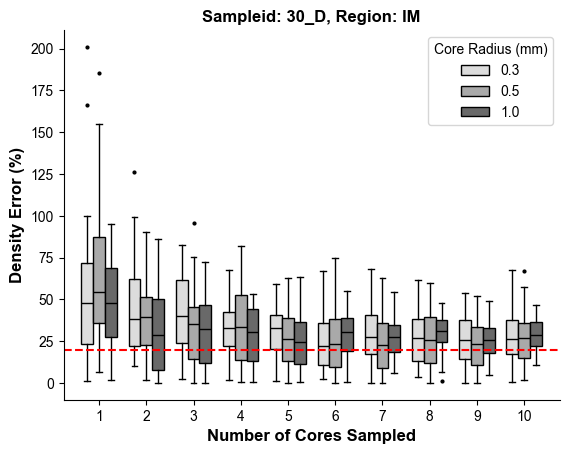

In [22]:
offset = 0.25
width = 0.25

positions = np.arange(1, 11)

for sampleid in sampleids:

    plt.cla()
    plt.clf()

    data_600 = [im_600[(im_600["sampleid"] == sampleid) & (im_600["n_sampled"] == n)]["den_error"].values * 100 for n in positions]

    data_1000 = [im_1000[(im_1000["sampleid"] == sampleid) & (im_1000["n_sampled"] == n)]["den_error"].values * 100 for n in positions]

    data_2000 = [im_2000[(im_2000["sampleid"] == sampleid) & (im_2000["n_sampled"] == n)]["den_error"].values * 100 for n in positions]


    plt.boxplot(data_600, positions=[p - offset for p in positions], widths=width, label=0.3, flierprops=dict(marker="o", markerfacecolor="black", markersize=2, linestyle="none"), patch_artist=True, boxprops=dict(facecolor="gainsboro"), medianprops=dict(color="black"))
    
    plt.boxplot(data_1000, positions=positions, widths=width, label=0.5, flierprops=dict(marker="o", markerfacecolor="black", markersize=2, linestyle="none"), patch_artist=True, boxprops=dict(facecolor="darkgrey"), medianprops=dict(color="black"))

    plt.boxplot(data_2000, positions=[p + offset for p in positions], widths=width, label=1.0, flierprops=dict(marker="o", markerfacecolor="black", markersize=2, linestyle="none"), patch_artist=True, boxprops=dict(facecolor="dimgrey"), medianprops=dict(color="black"))

    plt.xticks(positions, positions, fontsize=10, fontname="Arial")
    plt.yticks(fontsize=10, fontname="Arial")

    plt.xlabel("Number of Cores Sampled", fontdict=font_dict)
    plt.ylabel("Density Error (%)", fontdict=font_dict)

    plt.axhline(20, color="red", linestyle="--")
    
    plt.legend(title="Core Radius (mm)", prop={"size": 10, "family": "Arial"}, title_fontproperties={"size": 10, "family": "Arial"})

    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)

    plt.title(f"Sampleid: {sampleid}, Region: IM", fontdict=font_dict)

    plt.savefig(f"../../../../Data/Plots/DensityError/PerSampleBox/{sampleid}_IM_denerror.png", dpi=300, transparent=True)

#### Density

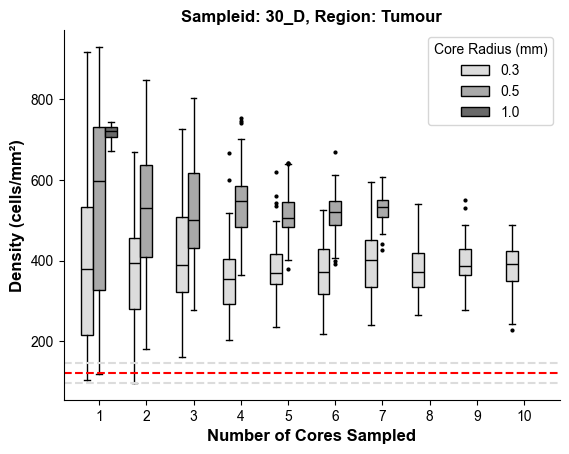

In [23]:
offset = 0.25
width = 0.25

positions = np.arange(1, 11)

for sampleid in sampleids:

    plt.cla()
    plt.clf()

    data_600 = [tum_600[(tum_600["sampleid"] == sampleid) & (tum_600["n_sampled"] == n)]["density_mean"].values for n in positions]

    data_1000 = [tum_1000[(tum_1000["sampleid"] == sampleid) & (tum_1000["n_sampled"] == n)]["density_mean"].values for n in positions]

    data_2000 = [tum_2000[(tum_2000["sampleid"] == sampleid) & (tum_2000["n_sampled"] == n)]["density_mean"].values for n in positions]


    plt.boxplot(data_600, positions=[p - offset for p in positions], widths=width, label=0.3, flierprops=dict(marker="o", markerfacecolor="black", markersize=2, linestyle="none"), patch_artist=True, boxprops=dict(facecolor="gainsboro"), medianprops=dict(color="black"))

    plt.boxplot(data_1000, positions=positions, widths=width, label=0.5, flierprops=dict(marker="o", markerfacecolor="black", markersize=2, linestyle="none"), patch_artist=True, boxprops=dict(facecolor="darkgrey"), medianprops=dict(color="black"))

    plt.boxplot(data_2000, positions=[p + offset for p in positions], widths=width, label=1.0, flierprops=dict(marker="o", markerfacecolor="black", markersize=2, linestyle="none"), patch_artist=True, boxprops=dict(facecolor="dimgrey"), medianprops=dict(color="black"))

    plt.xticks(positions, positions, fontsize=10, fontname="Arial")
    plt.yticks(fontsize=10, fontname="Arial")

    plt.xlabel("Number of Cores Sampled", fontdict=font_dict)
    plt.ylabel("Density (cells/mm\u00b2)", fontdict=font_dict)

    ws_mean = ws[(ws["sampleid"] == sampleid) & (ws["region"] == "tumour")]["ws_density"].values[0]
    
    plt.axhline(ws_mean, color="red", linestyle="--")
    plt.axhline(ws_mean * 0.8, color="gainsboro", linestyle="--")
    plt.axhline(ws_mean * 1.2, color="gainsboro", linestyle="--")

    plt.legend(title="Core Radius (mm)", prop={"size": 10, "family": "Arial"}, title_fontproperties={"size": 10, "family": "Arial"})

    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)

    plt.title(f"Sampleid: {sampleid}, Region: Tumour", fontdict=font_dict)

    plt.savefig(f"../../../../Data/Plots/Density/PerSampleBox/{sampleid}_tumour_denerror.png", dpi=300, transparent=True)

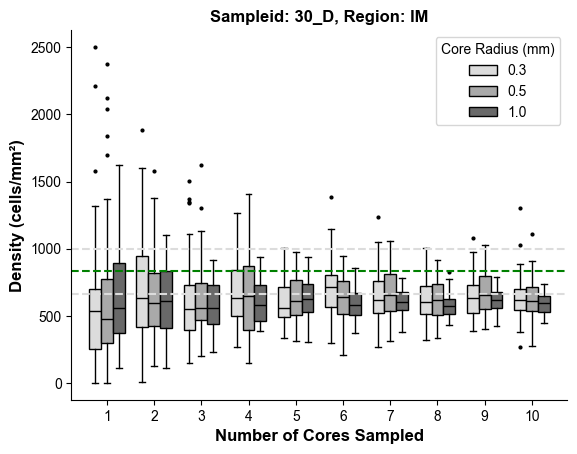

In [25]:
offset = 0.25
width = 0.25

positions = np.arange(1, 11)

for sampleid in sampleids:

    plt.cla()
    plt.clf()

    data_600 = [im_600[(im_600["sampleid"] == sampleid) & (im_600["n_sampled"] == n)]["density_mean"].values for n in positions]

    data_1000 = [im_1000[(im_1000["sampleid"] == sampleid) & (im_1000["n_sampled"] == n)]["density_mean"].values for n in positions]

    data_2000 = [im_2000[(im_2000["sampleid"] == sampleid) & (im_2000["n_sampled"] == n)]["density_mean"].values for n in positions]


    plt.boxplot(data_600, positions=[p - offset for p in positions], widths=width, label=0.3, flierprops=dict(marker="o", markerfacecolor="black", markersize=2, linestyle="none"), patch_artist=True, boxprops=dict(facecolor="gainsboro"), medianprops=dict(color="black"))

    plt.boxplot(data_1000, positions=positions, widths=width, label=0.5, flierprops=dict(marker="o", markerfacecolor="black", markersize=2, linestyle="none"), patch_artist=True, boxprops=dict(facecolor="darkgrey"), medianprops=dict(color="black"))

    plt.boxplot(data_2000, positions=[p + offset for p in positions], widths=width, label=1.0, flierprops=dict(marker="o", markerfacecolor="black", markersize=2, linestyle="none"), patch_artist=True, boxprops=dict(facecolor="dimgrey"), medianprops=dict(color="black"))

    plt.xticks(positions, positions, fontsize=10, fontname="Arial")
    plt.yticks(fontsize=10, fontname="Arial")

    plt.xlabel("Number of Cores Sampled", fontdict=font_dict)
    plt.ylabel("Density (cells/mm\u00b2)", fontdict=font_dict)

    ws_mean = ws[(ws["sampleid"] == sampleid) & (ws["region"] == "outer_IM")]["ws_density"].values[0]
    
    plt.axhline(ws_mean, color="green", linestyle="--")
    plt.axhline(ws_mean * 0.8, color="gainsboro", linestyle="--")
    plt.axhline(ws_mean * 1.2, color="gainsboro", linestyle="--")

    plt.legend(title="Core Radius (mm)", prop={"size": 10, "family": "Arial"}, title_fontproperties={"size": 10, "family": "Arial"})

    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)

    plt.title(f"Sampleid: {sampleid}, Region: IM", fontdict=font_dict)

    plt.savefig(f"../../../../Data/Plots/Density/PerSampleBox/{sampleid}_IM_denerror.png", dpi=300, transparent=True)

### Correlation Heatmaps

In [ ]:
# Consider 1 - R2 for error metric

#### Densities

In [19]:
def get_r2(group):
    r, p_value = spearmanr(group["density_mean"], group["ws_density"])
    return r ** 2

In [20]:
r2_tum = tma_total[tma_total["region"] == "tumour"].groupby(["core_radius", "n_sampled"]).apply(get_r2).reset_index(name="r2")

r2_im = tma_total[tma_total["region"] == "outer_IM"].groupby(["core_radius", "n_sampled"]).apply(get_r2).reset_index(name="r2")

C:\Users\Michael\AppData\Local\Temp\ipykernel_28180\2359807499.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  r2_tum = tma_total[tma_total["region"] == "tumour"].groupby(["core_radius", "n_sampled"]).apply(get_r2).reset_index(name="r2")
C:\Users\Michael\AppData\Local\Temp\ipykernel_28180\2359807499.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  r2_im = tma_total[tma_total["region"] == "outer_IM"].

In [27]:
r2_tum["core_radius"] = r2_tum["core_radius"] * 2
r2_tum = r2_tum.rename(columns={"core_radius": "core_diameter"})

r2_im["core_radius"] = r2_im["core_radius"] * 2
r2_im = r2_im.rename(columns={"core_radius": "core_diameter"})

In [30]:
heatmap_tum = r2_tum.pivot(index="core_diameter", columns="n_sampled", values="r2")
heatmap_im = r2_im.pivot(index="core_diameter", columns="n_sampled", values="r2")

C:\Users\Michael\AppData\Local\Temp\ipykernel_28180\4154905186.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontname="Arial")


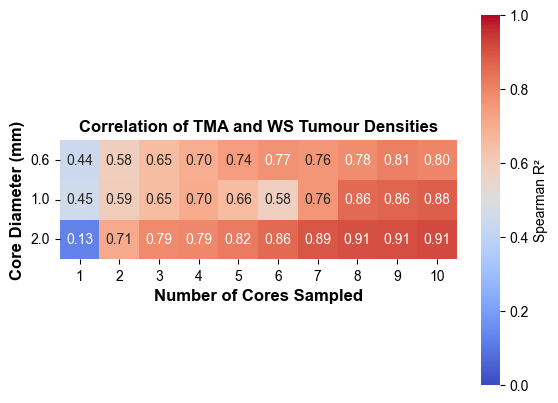

In [35]:
sns.heatmap(heatmap_tum, cmap="coolwarm", annot=True, fmt=".2f", cbar_kws={"label": "Spearman R\u00b2"}, annot_kws={"fontsize": 10, "fontname": "Arial"}, vmin=0, vmax=1.0, square=True)

cbar = plt.gca().collections[0].colorbar
cbar.set_label("Spearman R\u00b2", fontdict={"fontname": "Arial", "fontsize": 10})
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontname="Arial")

plt.xlabel("Number of Cores Sampled", fontdict=font_dict)
plt.ylabel("Core Diameter (mm)", fontdict=font_dict)

plt.xticks(fontsize=10, fontname="Arial")
plt.yticks(fontsize=10, fontname="Arial")

plt.gca().set_yticklabels(plt.gca().get_yticklabels(), rotation=0)

plt.title("Correlation of TMA and WS Tumour Densities", fontdict=font_dict)

plt.savefig("../../../../Data/Plots/Heatmaps/den_tumour_r2.png", dpi=300, transparent=True)

C:\Users\Michael\AppData\Local\Temp\ipykernel_28180\2879335791.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontname="Arial")


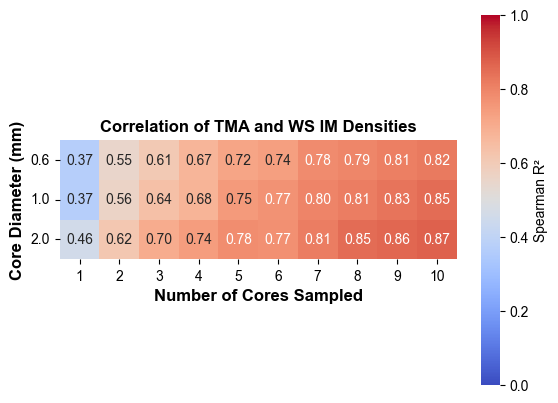

In [36]:
sns.heatmap(heatmap_im, cmap="coolwarm", annot=True, fmt=".2f", cbar_kws={"label": "Spearman R\u00b2"}, annot_kws={"fontsize": 10, "fontname": "Arial"}, vmin=0, vmax=1.0, square=True)

cbar = plt.gca().collections[0].colorbar
cbar.set_label("Spearman R\u00b2", fontdict={"fontname": "Arial", "fontsize": 10})
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontname="Arial")

plt.xlabel("Number of Cores Sampled", fontdict=font_dict)
plt.ylabel("Core Diameter (mm)", fontdict=font_dict)

plt.xticks(fontsize=10, fontname="Arial")
plt.yticks(fontsize=10, fontname="Arial")

plt.gca().set_yticklabels(plt.gca().get_yticklabels(), rotation=0)

plt.title("Correlation of TMA and WS IM Densities", fontdict=font_dict)

plt.savefig("../../../../Data/Plots/Heatmaps/den_IM_r2.png", dpi=300, transparent=True)

#### Nearest Neighbour Distances

In [31]:
def get_nn_r2(group):
    r, p_value = spearmanr(group["nearest_neighbour_mean"], group["ws_n_neighbour"])
    return r ** 2

In [ ]:
tma_heatmap = tma_total.dropna(subset=["nearest_neighbour_mean", "ws_n_neighbour"]).reset_index(drop=True)

r2_tum = tma_heatmap[tma_heatmap["region"] == "tumour"].groupby(["core_radius", "n_sampled"]).apply(get_nn_r2).reset_index(name="r2")

r2_im = tma_heatmap[tma_heatmap["region"] == "outer_IM"].groupby(["core_radius", "n_sampled"]).apply(get_nn_r2).reset_index(name="r2")

In [34]:
heatmap_tum = r2_tum.pivot(index="core_radius", columns="n_sampled", values="r2")
heatmap_im = r2_im.pivot(index="core_radius", columns="n_sampled", values="r2")

C:\Users\Michael\AppData\Local\Temp\ipykernel_38032\3353926816.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontname="Arial")


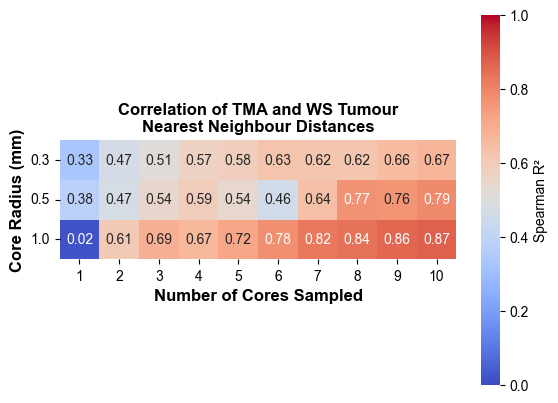

In [35]:
sns.heatmap(heatmap_tum, cmap="coolwarm", annot=True, fmt=".2f", cbar_kws={"label": "Spearman R\u00b2"}, annot_kws={"fontsize": 10, "fontname": "Arial"}, vmin=0, vmax=1.0, square=True)

cbar = plt.gca().collections[0].colorbar
cbar.set_label("Spearman R\u00b2", fontdict={"fontname": "Arial", "fontsize": 10})
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontname="Arial")

plt.xlabel("Number of Cores Sampled", fontdict=font_dict)
plt.ylabel("Core Radius (mm)", fontdict=font_dict)

plt.xticks(fontsize=10, fontname="Arial")
plt.yticks(fontsize=10, fontname="Arial")

plt.gca().set_yticklabels(plt.gca().get_yticklabels(), rotation=0)

plt.title("Correlation of TMA and WS Tumour\nNearest Neighbour Distances", fontdict=font_dict)

plt.savefig("../../../../Data/Plots/Heatmaps/NN_tumour_r2.png", dpi=300, transparent=True)

C:\Users\Michael\AppData\Local\Temp\ipykernel_38032\3726441579.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontname="Arial")


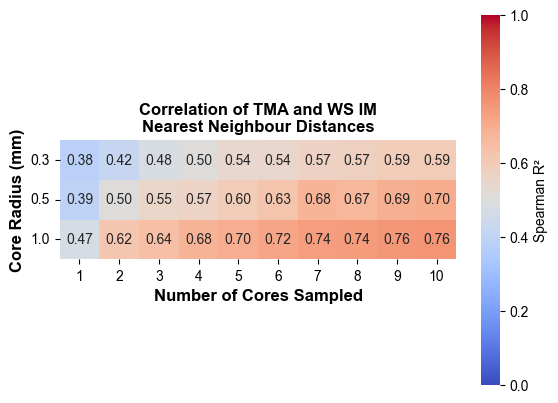

In [36]:
sns.heatmap(heatmap_im, cmap="coolwarm", annot=True, fmt=".2f", cbar_kws={"label": "Spearman R\u00b2"}, annot_kws={"fontsize": 10, "fontname": "Arial"}, vmin=0, vmax=1.0, square=True)

cbar = plt.gca().collections[0].colorbar
cbar.set_label("Spearman R\u00b2", fontdict={"fontname": "Arial", "fontsize": 10})
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontname="Arial")

plt.xlabel("Number of Cores Sampled", fontdict=font_dict)
plt.ylabel("Core Radius (mm)", fontdict=font_dict)

plt.xticks(fontsize=10, fontname="Arial")
plt.yticks(fontsize=10, fontname="Arial")

plt.gca().set_yticklabels(plt.gca().get_yticklabels(), rotation=0)

plt.title("Correlation of TMA and WS IM\nNearest Neighbour Distances", fontdict=font_dict)

plt.savefig("../../../../Data/Plots/Heatmaps/NN_IM_r2.png", dpi=300, transparent=True)

## Stastistical Correlation Differences

### Spearman R2 comparisons

In [16]:
stats.wilcoxon(r2_tum[r2_tum["core_radius"] == 0.3]["r2"], r2_tum[r2_tum["core_radius"] == 1.0]["r2"])

WilcoxonResult(statistic=10.0, pvalue=0.083984375)

In [17]:
stats.wilcoxon(r2_im[r2_im["core_radius"] == 0.3]["r2"], r2_im[r2_im["core_radius"] == 1.0]["r2"])

WilcoxonResult(statistic=0.0, pvalue=0.001953125)

## Plot Sampling Simulation Example

In [3]:
sample = "01_F"

In [4]:
spatdat = SpatDat(sample, parent_filepath)

In [5]:
tum = spatdat.subset_annotation("tumour")

In [14]:
partition = spatdat.subset_annotation("extended_partition")

In [15]:
from shapely import affinity, MultiPolygon, Polygon

swapped = affinity.scale(tum, xfact=1, yfact=-1, origin=(0, 0))

swapped_partition = affinity.scale(partition, xfact=1, yfact=-1, origin=(0, 0))

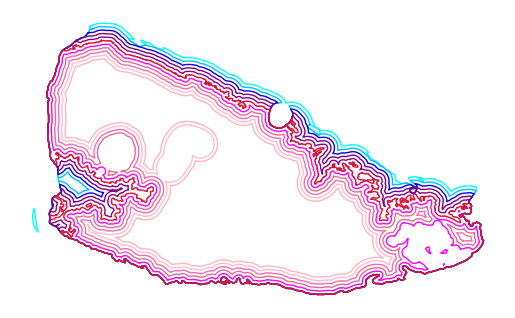

In [17]:
for idx, buff in enumerate([-1000, -800, -600, -400, -200, 1000, 800, 600, 400, 200, 0]):

    buff = buff/microns_per_pixel
    
    buffered = swapped.buffer(buff)

    buffered = buffered.intersection(swapped_partition)

    if buff == 0:
        width = 1.25
    else:
        width = 0.75

    colour = ["lightpink",
 "pink",
 "hotpink",
 "palevioletred",
 "magenta",
 "cyan",
 "deepskyblue",
 "blue",
 "purple",
 "darkmagenta",
 "crimson"][idx]

    if isinstance(buffered, MultiPolygon):
        for geom in buffered.geoms:
            plt.plot(*geom.exterior.xy, color=colour, linewidth=1)
    elif isinstance(buffered, Polygon):
        plt.plot(*buffered.exterior.xy, color=colour, linewidth=1)

    plt.gca().set_aspect("equal")

    plt.axis("off")

    plt.savefig(f"../../../../Data/Plots/example_buffered_image.png", dpi=900, transparent=True, bbox_inches="tight")

In [38]:
# Use a single specimen as an example
sample = "08_J"

In [39]:
# Load sample data
spatdat = SpatDat(sample, parent_filepath)

In [40]:
# Get annotation data
tum = spatdat.subset_annotation("tumour")
im = spatdat.subset_annotation("outer_IM_hull")

In [41]:
# Get examples of sampled cores for each core size

eg_tum_600 = loads(tum_600[(tum_600["sampleid"] == sample) & (tum_600["n_sampled"] == 5)]["cores"].iloc[6])
eg_tum_600 = gpd.GeoDataFrame(geometry=[eg_tum_600])

eg_im_600 = loads(im_600[(im_600["sampleid"] == sample) & (im_600["n_sampled"] == 5)]["cores"].iloc[1])
eg_im_600 = gpd.GeoDataFrame(geometry=[eg_im_600])


eg_tum_1000 = loads(tum_1000[(tum_1000["sampleid"] == sample) & (tum_1000["n_sampled"] == 5)]["cores"].iloc[1])
eg_tum_1000 = gpd.GeoDataFrame(geometry=[eg_tum_1000])

eg_im_1000 = loads(im_1000[(im_1000["sampleid"] == sample) & (im_1000["n_sampled"] == 5)]["cores"].iloc[1])
eg_im_1000 = gpd.GeoDataFrame(geometry=[eg_im_1000])


eg_tum_2000 = loads(tum_2000[(tum_2000["sampleid"] == sample) & (tum_2000["n_sampled"] == 5)]["cores"].iloc[12])
eg_tum_2000 = gpd.GeoDataFrame(geometry=[eg_tum_2000])

eg_im_2000 = loads(im_2000[(im_2000["sampleid"] == sample) & (im_2000["n_sampled"] == 5)]["cores"].iloc[1])
eg_im_2000 = gpd.GeoDataFrame(geometry=[eg_im_2000])

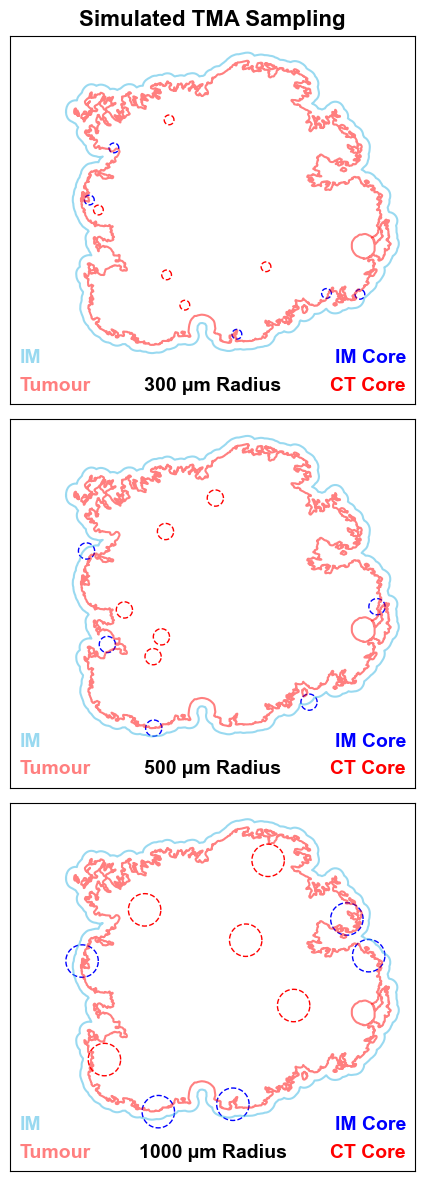

In [ ]:
# Plot column of tissue annotations with example simulated cores

fig, axes = plt.subplots(3, 1, figsize=(12, 12))

# 600 radius

axes[0].plot(*im.exterior.xy, color=(52/255, 181/255, 227/255), alpha=0.5)

for geom in tum.geoms:
    axes[0].plot(*geom.exterior.xy, color="red", alpha=0.5)

eg_tum_600.plot(color="None", edgecolor="red", linestyle="--", ax=axes[0])

eg_im_600.plot(color="None", edgecolor="blue", linestyle="--", ax=axes[0])

# 1000 radius

axes[1].plot(*im.exterior.xy, color=(52/255, 181/255, 227/255), alpha=0.5)

for geom in tum.geoms:
    axes[1].plot(*geom.exterior.xy, color="red", alpha=0.5)

eg_tum_1000.plot(color="None", edgecolor="red", linestyle="--", ax=axes[1])

eg_im_1000.plot(color="None", edgecolor="blue", linestyle="--", ax=axes[1])

# 2000 radius

axes[2].plot(*im.exterior.xy, color=(52/255, 181/255, 227/255), alpha=0.5)

for geom in tum.geoms:
    axes[2].plot(*geom.exterior.xy, color="red", alpha=0.5)

eg_tum_2000.plot(color="None", edgecolor="red", linestyle="--", ax=axes[2])

eg_im_2000.plot(color="None", edgecolor="blue", linestyle="--", ax=axes[2])

for ax in axes:
    # ax.set_aspect("equal")
    ax.set_xticks([10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000])
    ax.set_yticks([10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000])
    ax.set_yticks([])
    ax.set_xticks([])
    ax.invert_yaxis()
    ax.yaxis.set_label_position("right")

axes[0].text(65000, 105000, "300 \u00b5m Radius", fontname="Arial", fontsize=14, fontweight="bold", ha="center", va="center")

axes[0].text(12500, 105000, "Tumour", fontname="Arial", fontsize=14, fontweight="bold", ha="left", va="center", color="red", alpha=0.5)

axes[0].text(12500, 97500, "IM", fontname="Arial", fontsize=14, fontweight="bold", ha="left", va="center", color=(52/255, 181/255, 227/255), alpha=0.5)

axes[0].text(117500, 105000, "CT Core", fontname="Arial", fontsize=14, fontweight="bold", ha="right", va="center", color="red")

axes[0].text(117500, 97500, "IM Core", fontname="Arial", fontsize=14, fontweight="bold", ha="right", va="center", color="blue")


axes[1].text(65000, 105000, "500 \u00b5m Radius", fontname="Arial", fontsize=14, fontweight="bold", ha="center", va="center")

axes[1].text(12500, 105000, "Tumour", fontname="Arial", fontsize=14, fontweight="bold", ha="left", va="center", color="red", alpha=0.5)

axes[1].text(12500, 97500, "IM", fontname="Arial", fontsize=14, fontweight="bold", ha="left", va="center", color=(52/255, 181/255, 227/255), alpha=0.5)

axes[1].text(117500, 105000, "CT Core", fontname="Arial", fontsize=14, fontweight="bold", ha="right", va="center", color="red")

axes[1].text(117500, 97500, "IM Core", fontname="Arial", fontsize=14, fontweight="bold", ha="right", va="center", color="blue")


axes[2].text(65000, 105000, "1000 \u00b5m Radius", fontname="Arial", fontsize=14, fontweight="bold", ha="center", va="center")

axes[2].text(12500, 105000, "Tumour", fontname="Arial", fontsize=14, fontweight="bold", ha="left", va="center", color="red", alpha=0.5)

axes[2].text(12500, 97500, "IM", fontname="Arial", fontsize=14, fontweight="bold", ha="left", va="center", color=(52/255, 181/255, 227/255), alpha=0.5)

axes[2].text(117500, 105000, "CT Core", fontname="Arial", fontsize=14, fontweight="bold", ha="right", va="center", color="red")

axes[2].text(117500, 97500, "IM Core", fontname="Arial", fontsize=14, fontweight="bold", ha="right", va="center", color="blue")

# axes[0].set_ylabel("300 \u00b5m", fontname="Arial", fontsize=12, fontweight="bold")
# axes[1].set_ylabel("500 \u00b5m", fontname="Arial", fontsize=12, fontweight="bold")
# axes[2].set_ylabel("1000 \u00b5m", fontname="Arial", fontsize=12, fontweight="bold")

fig.suptitle("Simulated TMA Sampling", fontname="Arial", fontsize=16, fontweight="bold")

# fig.text(0.72, 0.485, "Radius", fontname="Arial", fontsize=14, fontweight="bold", ha="center", va="center", rotation=90)

plt.tight_layout()

plt.savefig("../../../../Data/Plots/sampling_example.png", dpi=900, transparent=True, bbox_inches="tight")


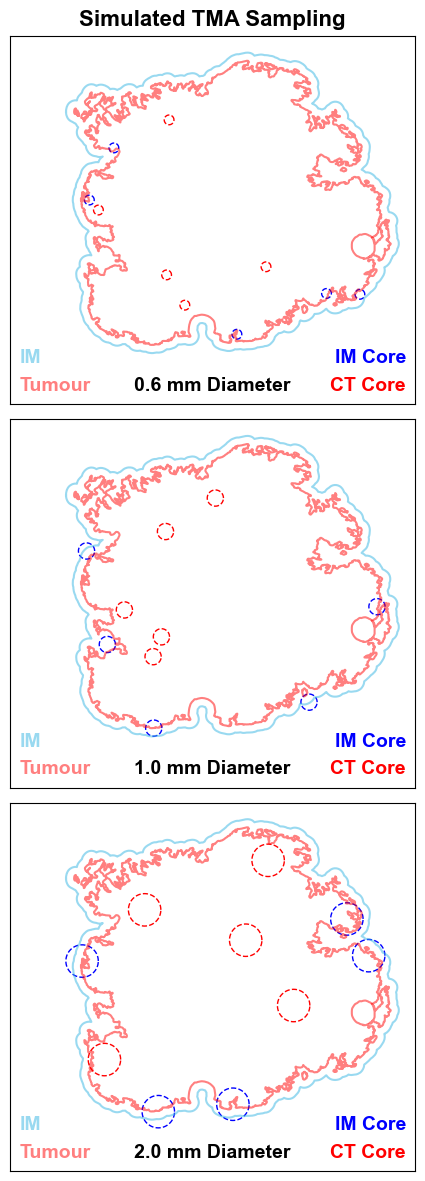

In [43]:
# Plot column of tissue annotations with example simulated cores

fig, axes = plt.subplots(3, 1, figsize=(12, 12))

# 600 radius

axes[0].plot(*im.exterior.xy, color=(52/255, 181/255, 227/255), alpha=0.5)

for geom in tum.geoms:
    axes[0].plot(*geom.exterior.xy, color="red", alpha=0.5)

eg_tum_600.plot(color="None", edgecolor="red", linestyle="--", ax=axes[0])

eg_im_600.plot(color="None", edgecolor="blue", linestyle="--", ax=axes[0])

# 1000 radius

axes[1].plot(*im.exterior.xy, color=(52/255, 181/255, 227/255), alpha=0.5)

for geom in tum.geoms:
    axes[1].plot(*geom.exterior.xy, color="red", alpha=0.5)

eg_tum_1000.plot(color="None", edgecolor="red", linestyle="--", ax=axes[1])

eg_im_1000.plot(color="None", edgecolor="blue", linestyle="--", ax=axes[1])

# 2000 radius

axes[2].plot(*im.exterior.xy, color=(52/255, 181/255, 227/255), alpha=0.5)

for geom in tum.geoms:
    axes[2].plot(*geom.exterior.xy, color="red", alpha=0.5)

eg_tum_2000.plot(color="None", edgecolor="red", linestyle="--", ax=axes[2])

eg_im_2000.plot(color="None", edgecolor="blue", linestyle="--", ax=axes[2])

for ax in axes:
    # ax.set_aspect("equal")
    ax.set_xticks([10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000])
    ax.set_yticks([10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000])
    ax.set_yticks([])
    ax.set_xticks([])
    ax.invert_yaxis()
    ax.yaxis.set_label_position("right")

axes[0].text(65000, 105000, "0.6 mm Diameter", fontname="Arial", fontsize=14, fontweight="bold", ha="center", va="center")

axes[0].text(12500, 105000, "Tumour", fontname="Arial", fontsize=14, fontweight="bold", ha="left", va="center", color="red", alpha=0.5)

axes[0].text(12500, 97500, "IM", fontname="Arial", fontsize=14, fontweight="bold", ha="left", va="center", color=(52/255, 181/255, 227/255), alpha=0.5)

axes[0].text(117500, 105000, "CT Core", fontname="Arial", fontsize=14, fontweight="bold", ha="right", va="center", color="red")

axes[0].text(117500, 97500, "IM Core", fontname="Arial", fontsize=14, fontweight="bold", ha="right", va="center", color="blue")


axes[1].text(65000, 105000, "1.0 mm Diameter", fontname="Arial", fontsize=14, fontweight="bold", ha="center", va="center")

axes[1].text(12500, 105000, "Tumour", fontname="Arial", fontsize=14, fontweight="bold", ha="left", va="center", color="red", alpha=0.5)

axes[1].text(12500, 97500, "IM", fontname="Arial", fontsize=14, fontweight="bold", ha="left", va="center", color=(52/255, 181/255, 227/255), alpha=0.5)

axes[1].text(117500, 105000, "CT Core", fontname="Arial", fontsize=14, fontweight="bold", ha="right", va="center", color="red")

axes[1].text(117500, 97500, "IM Core", fontname="Arial", fontsize=14, fontweight="bold", ha="right", va="center", color="blue")


axes[2].text(65000, 105000, "2.0 mm Diameter", fontname="Arial", fontsize=14, fontweight="bold", ha="center", va="center")

axes[2].text(12500, 105000, "Tumour", fontname="Arial", fontsize=14, fontweight="bold", ha="left", va="center", color="red", alpha=0.5)

axes[2].text(12500, 97500, "IM", fontname="Arial", fontsize=14, fontweight="bold", ha="left", va="center", color=(52/255, 181/255, 227/255), alpha=0.5)

axes[2].text(117500, 105000, "CT Core", fontname="Arial", fontsize=14, fontweight="bold", ha="right", va="center", color="red")

axes[2].text(117500, 97500, "IM Core", fontname="Arial", fontsize=14, fontweight="bold", ha="right", va="center", color="blue")

# axes[0].set_ylabel("300 \u00b5m", fontname="Arial", fontsize=12, fontweight="bold")
# axes[1].set_ylabel("500 \u00b5m", fontname="Arial", fontsize=12, fontweight="bold")
# axes[2].set_ylabel("1000 \u00b5m", fontname="Arial", fontsize=12, fontweight="bold")

fig.suptitle("Simulated TMA Sampling", fontname="Arial", fontsize=16, fontweight="bold")

# fig.text(0.72, 0.485, "Radius", fontname="Arial", fontsize=14, fontweight="bold", ha="center", va="center", rotation=90)

plt.tight_layout()

plt.savefig("../../../../Data/Plots/sampling_example_vert_diameter.png", dpi=900, transparent=True, bbox_inches="tight")


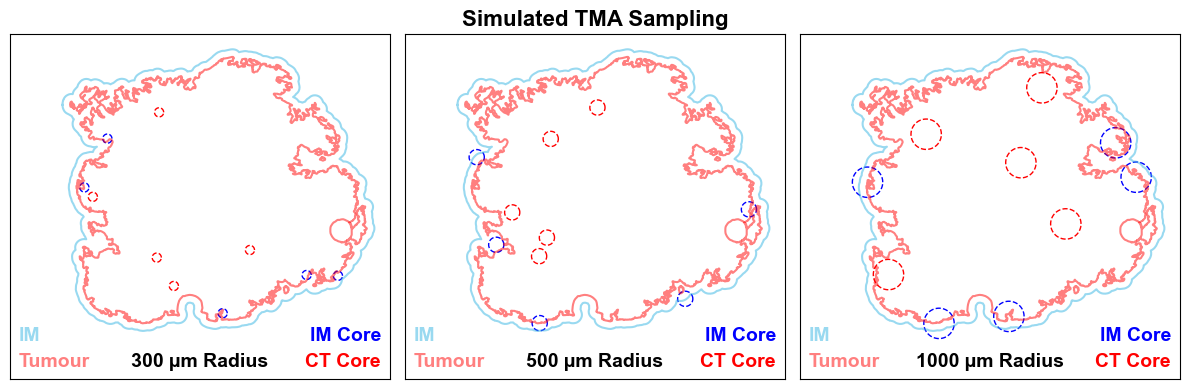

In [18]:
# Plot column of tissue annotations with example simulated cores

fig, axes = plt.subplots(1, 3, figsize=(12, 12))

# 600 radius

axes[0].plot(*im.exterior.xy, color=(52/255, 181/255, 227/255), alpha=0.5)

for geom in tum.geoms:
    axes[0].plot(*geom.exterior.xy, color="red", alpha=0.5)

eg_tum_600.plot(color="None", edgecolor="red", linestyle="--", ax=axes[0])

eg_im_600.plot(color="None", edgecolor="blue", linestyle="--", ax=axes[0])

# 1000 radius

axes[1].plot(*im.exterior.xy, color=(52/255, 181/255, 227/255), alpha=0.5)

for geom in tum.geoms:
    axes[1].plot(*geom.exterior.xy, color="red", alpha=0.5)

eg_tum_1000.plot(color="None", edgecolor="red", linestyle="--", ax=axes[1])

eg_im_1000.plot(color="None", edgecolor="blue", linestyle="--", ax=axes[1])

# 2000 radius

axes[2].plot(*im.exterior.xy, color=(52/255, 181/255, 227/255), alpha=0.5)

for geom in tum.geoms:
    axes[2].plot(*geom.exterior.xy, color="red", alpha=0.5)

eg_tum_2000.plot(color="None", edgecolor="red", linestyle="--", ax=axes[2])

eg_im_2000.plot(color="None", edgecolor="blue", linestyle="--", ax=axes[2])

for ax in axes:
    # ax.set_aspect("equal")
    ax.set_xticks([10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000])
    ax.set_yticks([10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000])
    ax.set_yticks([])
    ax.set_xticks([])
    ax.invert_yaxis()
    ax.yaxis.set_label_position("right")

axes[0].text(65000, 105000, "300 \u00b5m Radius", fontname="Arial", fontsize=14, fontweight="bold", ha="center", va="center")

axes[0].text(12500, 105000, "Tumour", fontname="Arial", fontsize=14, fontweight="bold", ha="left", va="center", color="red", alpha=0.5)

axes[0].text(12500, 97500, "IM", fontname="Arial", fontsize=14, fontweight="bold", ha="left", va="center", color=(52/255, 181/255, 227/255), alpha=0.5)

axes[0].text(117500, 105000, "CT Core", fontname="Arial", fontsize=14, fontweight="bold", ha="right", va="center", color="red")

axes[0].text(117500, 97500, "IM Core", fontname="Arial", fontsize=14, fontweight="bold", ha="right", va="center", color="blue")


axes[1].text(65000, 105000, "500 \u00b5m Radius", fontname="Arial", fontsize=14, fontweight="bold", ha="center", va="center")

axes[1].text(12500, 105000, "Tumour", fontname="Arial", fontsize=14, fontweight="bold", ha="left", va="center", color="red", alpha=0.5)

axes[1].text(12500, 97500, "IM", fontname="Arial", fontsize=14, fontweight="bold", ha="left", va="center", color=(52/255, 181/255, 227/255), alpha=0.5)

axes[1].text(117500, 105000, "CT Core", fontname="Arial", fontsize=14, fontweight="bold", ha="right", va="center", color="red")

axes[1].text(117500, 97500, "IM Core", fontname="Arial", fontsize=14, fontweight="bold", ha="right", va="center", color="blue")


axes[2].text(65000, 105000, "1000 \u00b5m Radius", fontname="Arial", fontsize=14, fontweight="bold", ha="center", va="center")

axes[2].text(12500, 105000, "Tumour", fontname="Arial", fontsize=14, fontweight="bold", ha="left", va="center", color="red", alpha=0.5)

axes[2].text(12500, 97500, "IM", fontname="Arial", fontsize=14, fontweight="bold", ha="left", va="center", color=(52/255, 181/255, 227/255), alpha=0.5)

axes[2].text(117500, 105000, "CT Core", fontname="Arial", fontsize=14, fontweight="bold", ha="right", va="center", color="red")

axes[2].text(117500, 97500, "IM Core", fontname="Arial", fontsize=14, fontweight="bold", ha="right", va="center", color="blue")

# axes[0].set_ylabel("300 \u00b5m", fontname="Arial", fontsize=12, fontweight="bold")
# axes[1].set_ylabel("500 \u00b5m", fontname="Arial", fontsize=12, fontweight="bold")
# axes[2].set_ylabel("1000 \u00b5m", fontname="Arial", fontsize=12, fontweight="bold")

axes[1].set_title("Simulated TMA Sampling", fontname="Arial", fontsize=16, fontweight="bold", loc="center")

# fig.text(0.72, 0.485, "Radius", fontname="Arial", fontsize=14, fontweight="bold", ha="center", va="center", rotation=90)

plt.tight_layout()

plt.savefig("../../../../Data/Plots/sampling_example_horizontal.png", dpi=900, transparent=True, bbox_inches="tight")


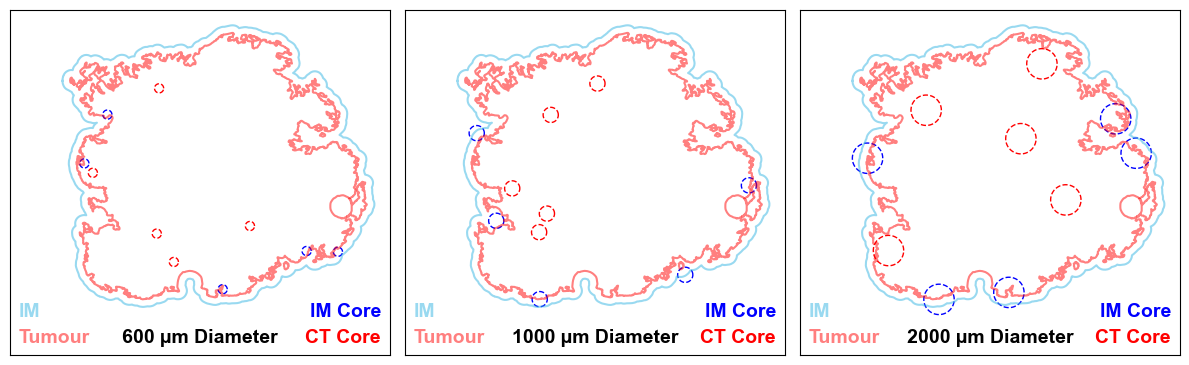

In [11]:
# Plot column of tissue annotations with example simulated cores

fig, axes = plt.subplots(1, 3, figsize=(12, 12))

# 600 radius

axes[0].plot(*im.exterior.xy, color=(52/255, 181/255, 227/255), alpha=0.5)

for geom in tum.geoms:
    axes[0].plot(*geom.exterior.xy, color="red", alpha=0.5)

eg_tum_600.plot(color="None", edgecolor="red", linestyle="--", ax=axes[0])

eg_im_600.plot(color="None", edgecolor="blue", linestyle="--", ax=axes[0])

# 1000 radius

axes[1].plot(*im.exterior.xy, color=(52/255, 181/255, 227/255), alpha=0.5)

for geom in tum.geoms:
    axes[1].plot(*geom.exterior.xy, color="red", alpha=0.5)

eg_tum_1000.plot(color="None", edgecolor="red", linestyle="--", ax=axes[1])

eg_im_1000.plot(color="None", edgecolor="blue", linestyle="--", ax=axes[1])

# 2000 radius

axes[2].plot(*im.exterior.xy, color=(52/255, 181/255, 227/255), alpha=0.5)

for geom in tum.geoms:
    axes[2].plot(*geom.exterior.xy, color="red", alpha=0.5)

eg_tum_2000.plot(color="None", edgecolor="red", linestyle="--", ax=axes[2])

eg_im_2000.plot(color="None", edgecolor="blue", linestyle="--", ax=axes[2])

for ax in axes:
    # ax.set_aspect("equal")
    ax.set_xticks([10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000])
    ax.set_yticks([10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000])
    ax.set_yticks([])
    ax.set_xticks([])
    ax.invert_yaxis()
    ax.yaxis.set_label_position("right")

axes[0].text(65000, 105000, "600 \u00b5m Diameter", fontname="Arial", fontsize=14, fontweight="bold", ha="center", va="center")

axes[0].text(12500, 105000, "Tumour", fontname="Arial", fontsize=14, fontweight="bold", ha="left", va="center", color="red", alpha=0.5)

axes[0].text(12500, 97500, "IM", fontname="Arial", fontsize=14, fontweight="bold", ha="left", va="center", color=(52/255, 181/255, 227/255), alpha=0.5)

axes[0].text(117500, 105000, "CT Core", fontname="Arial", fontsize=14, fontweight="bold", ha="right", va="center", color="red")

axes[0].text(117500, 97500, "IM Core", fontname="Arial", fontsize=14, fontweight="bold", ha="right", va="center", color="blue")


axes[1].text(65000, 105000, "1000 \u00b5m Diameter", fontname="Arial", fontsize=14, fontweight="bold", ha="center", va="center")

axes[1].text(12500, 105000, "Tumour", fontname="Arial", fontsize=14, fontweight="bold", ha="left", va="center", color="red", alpha=0.5)

axes[1].text(12500, 97500, "IM", fontname="Arial", fontsize=14, fontweight="bold", ha="left", va="center", color=(52/255, 181/255, 227/255), alpha=0.5)

axes[1].text(117500, 105000, "CT Core", fontname="Arial", fontsize=14, fontweight="bold", ha="right", va="center", color="red")

axes[1].text(117500, 97500, "IM Core", fontname="Arial", fontsize=14, fontweight="bold", ha="right", va="center", color="blue")


axes[2].text(65000, 105000, "2000 \u00b5m Diameter", fontname="Arial", fontsize=14, fontweight="bold", ha="center", va="center")

axes[2].text(12500, 105000, "Tumour", fontname="Arial", fontsize=14, fontweight="bold", ha="left", va="center", color="red", alpha=0.5)

axes[2].text(12500, 97500, "IM", fontname="Arial", fontsize=14, fontweight="bold", ha="left", va="center", color=(52/255, 181/255, 227/255), alpha=0.5)

axes[2].text(117500, 105000, "CT Core", fontname="Arial", fontsize=14, fontweight="bold", ha="right", va="center", color="red")

axes[2].text(117500, 97500, "IM Core", fontname="Arial", fontsize=14, fontweight="bold", ha="right", va="center", color="blue")

# axes[0].set_ylabel("300 \u00b5m", fontname="Arial", fontsize=12, fontweight="bold")
# axes[1].set_ylabel("500 \u00b5m", fontname="Arial", fontsize=12, fontweight="bold")
# axes[2].set_ylabel("1000 \u00b5m", fontname="Arial", fontsize=12, fontweight="bold")

# axes[1].set_title("Simulated TMA Sampling", fontname="Arial", fontsize=16, fontweight="bold", loc="center")

# fig.text(0.72, 0.485, "Radius", fontname="Arial", fontsize=14, fontweight="bold", ha="center", va="center", rotation=90)

plt.tight_layout()

plt.savefig("../../../../Data/Plots/sampling_example_horizontal_diameter.png", dpi=900, transparent=True, bbox_inches="tight")